In [1]:
from typing import Dict

from src.utils.performance import PerformanceMonitor, monitor_performance
import src.word_count as wc
import pandas as pd

# WordCounter 구현 및 실험 

In [2]:
def evaluate_word_counter(word_counter: wc.WordCounter,
                          repeat: int = 1,
                          input_ratio: int = 1,
                          input_file_path: str = "example.txt"):
    """
    :param word_counter: 평가 대상이 되는 WordCounter instance
    :param repeat: 평가 반복 횟수
    :param input_ratio: Input 사이즈 배수
    :param input_file_path: Input 파일 경로 (default `example.txt`)
    :return: 
    """
    
    pm = PerformanceMonitor()
    pm_key = f"{word_counter.__class__.__name__}.count"
    
    reader = wc.Reader(file_path=input_file_path, repeat=input_ratio)
    
    @monitor_performance(pm=pm, name=pm_key)
    def run():
        word_counter.count(reader)

    for i in range(repeat):
        run()

    return pm.get_stats(pm_key), reader.get_file_size('kb')


1. 주어진 파일 크기의 배수를 대상으로 조사 (`input_ratios`)
2. 다양한 구현체를 대상으로 조사
    - `WordCounterImpl1`: 가장 단순하고 기본적인 구현 방식입니다. 순차적으로 파일을 읽어 dictionary로 관리되는 counter를 업데이트합니다.
    - `WordCounterImpl2`: 멀티스레딩 구현 방식입니다. 파일을 읽어 dictionary로 관리되는 counter를 업데이트 하는 방식은 WordCounterImpl1과 동일하지만 파일을 batch 단위로 나누어 worker 스레드에서 이를 처리하도록 구현하였습니다.
    - `WordCounterImpl3`: WordCounterImpl2와 비슷하게 병렬 처리 방식으로 접근하였습니다. 다만 스레드 대신 프로세스를 사용한다는 점에서 차이점이 있습니다. python의 multiprocessing 모듈 덕분에 코드가 직관적이고 깔끔하게 작성되었습니다.

In [3]:
input_ratios = [
    1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200
]

wc_candidates = [
    wc.WordCounterImpl1(),
    wc.WordCounterImpl2(),
    wc.WordCounterImpl3(),
]

performance_stats = []

for ir in input_ratios:
    for candidate in wc_candidates:
        stats, input_size = evaluate_word_counter(candidate, repeat=20, input_ratio=ir)
        performance_stats.append((candidate.__class__.__name__, input_size, stats.avg_time_p50))

In [4]:
performance_stats_df = pd.DataFrame(data=performance_stats, columns=["impl", "input size", "avg. time"])\
    .pivot(index='input size', columns='impl', values='avg. time')

performance_stats_df

impl,WordCounterImpl1,WordCounterImpl2,WordCounterImpl3
input size,,,
8.404297,2.851009,2.911308,151.819944
168.085938,48.293287,55.128466,167.096918
336.171875,94.224150,97.225948,190.187389
504.257812,143.705845,152.220076,198.943572
672.343750,189.468601,196.071343,227.659160
840.429688,237.321312,245.624781,245.131428
1008.515625,288.615660,296.069362,244.566202
1176.601562,331.336151,344.335318,262.803728
1344.687500,380.441644,392.199321,259.767857


<Axes: xlabel='input size'>

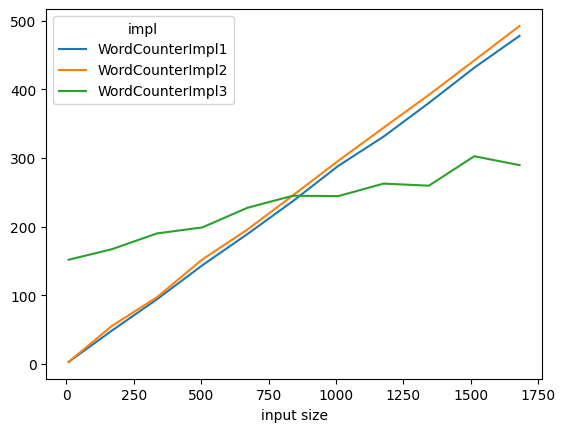

In [5]:
performance_stats_df.plot()

- `WordCounterImpl1`은 예상대로 input size가 늘어남에 따라 그에 비례하여 선형적으로 실행시간이 늘어남을 보여줍니다. 
- GIL의 존재로 python에서는 멀티스레드로 구현하여도 단일 CPU코어를 사용하는 제약 때문에 `WordCounterImpl2`는 `WordCounterImpl1`과 거의 동일한 성능을 보여주었습니다. input size가 늘어남에 따라 동기화를 위한 lock acquire race condition 확률이 늘어나면서 성능이 오히려 저하됨을 확인하였습니다.
- 실제 병렬 처리를 하는 `WordCounterImpl3`는 낮은 input ratio 구간에서는 리소스 생성과 같은 시스템 호출로 인하여 성능이 다른 두 구현체 보다 떨어지지만 input size가 높아질 수록 확연한 성능 차이를 보여주고 있습니다.

# TopNPicker 구현 및 실험

In [6]:
from itertools import islice, product
import random

def generate_n_size_count(n) -> Dict[str, int]:
    """
    단어 n개를 포함한 count dictionary 생성
    """
    
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    generator = (''.join(p) for p in product(alphabet, repeat=5))
    words = islice(generator, n)
    
    return {word: random.randint(1, 100) for word in words}


def evaluate_top_n_picker(top_n_picker: wc.TopNPicker,
                          count_dict: Dict[str, int],
                          n: int,
                          repeat: int = 1):
    """
    :param top_n_picker: 평가 대상이 되는 TopNPicker instance
    :param count_dict: count dictionary
    :param n: n
    :param repeat: 평가 반복 횟수
    :return: 
    """

    pm = PerformanceMonitor()
    pm_key = f"{top_n_picker.__class__.__name__}.count"

    @monitor_performance(pm=pm, name=pm_key)
    def run():
        top_n_picker.pick_top_n(count_dict, n)

    for i in range(repeat):
        run()

    return pm.get_stats(pm_key)

1. 고유 단어의 개수 (dictionary size) 대상으로 조사 (`dictionary_sizes`)
2. 다양한 구현체를 대상으로 조사
    - `TopNPickerImpl1`: python의 내장함수 `sorted`를 이용해 정렬한 후 상위 n개를 선택하는 방식으로 구현하였습니다.
    - `TopNPickerImpl2`: heap을 이용하여 하위 n개를 선택하는 python의 heapq 모듈을 사용하여 구현하였습니다.


In [7]:
dictionary_sizes = [
    1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800
]

top_n_picker_candidates = [
    wc.TopNPickerImpl1(),
    wc.TopNPickerImpl2(),
]

performance_stats = []

for ds in dictionary_sizes:
    count_dict = generate_n_size_count(ds)
    for candidate in top_n_picker_candidates:
        stats = evaluate_top_n_picker(candidate, count_dict, 5, repeat=20)
        performance_stats.append((candidate.__class__.__name__, ds, stats.avg_time_p50))

In [8]:
performance_stats_df = pd.DataFrame(data=performance_stats, columns=["impl", "dict size", "avg. time"])\
    .pivot(index='dict size', columns='impl', values='avg. time')

performance_stats_df

impl,TopNPickerImpl1,TopNPickerImpl2
dict size,,
1,0.000282,0.000347
50,0.004985,0.006221
100,0.010360,0.010014
150,0.016104,0.013070
200,0.023040,0.016299
250,0.031038,0.020027
300,0.036695,0.022086
350,0.045885,0.025099
400,0.054099,0.027570


<Axes: xlabel='dict size'>

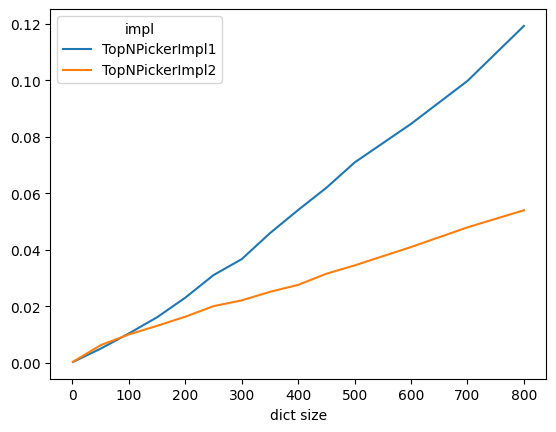

In [9]:
performance_stats_df.plot()

# 결론

In [10]:
# 전체 내용에서 `Rebecca`라는 단어가 몇번 나오는지 세는 가장 효율적인 파이썬 코드를 작성하시오.

input_path = 'example.txt'
find_word = 'Rebecca'

reader = wc.Reader(file_path=input_path)
word_counter = wc.WordCounterImpl1() if reader.get_file_size('kb') < 840 else wc.WordCounterImpl3()
count_dict = word_counter.count(reader, threshold=len(find_word))
find_count = count_dict.get(find_word.lower(), 0)

print("`Rebecca`라는 단어의 등장 횟수:", find_count)

`Rebecca`라는 단어의 등장 횟수: 27


In [11]:
# 4글자 이상의 단어 중, 가장 많이 나온 단어 (case-insensitive) Top 5를 추출하는 가장 효율적인 파이썬 코드를 작성하시오.

input_path = 'example.txt'
threshold = 4
n = 5

reader = wc.Reader(file_path=input_path)
word_counter = wc.WordCounterImpl1() if reader.get_file_size('kb') < 840 else wc.WordCounterImpl3()
count_dict = word_counter.count(reader, threshold=threshold)
top_n_picker = wc.TopNPickerImpl2()
top_n = top_n_picker.pick_top_n(count_dict, n)

print("가장 많이 등장한 단어 Top 5")
for row in top_n:
    print(f"{row[0]}\t\t({row[1]}회)")

가장 많이 등장한 단어 Top 5
rebecca		(27회)
with		(27회)
that		(26회)
fortune		(22회)
family		(13회)
